<a href="https://colab.research.google.com/github/ChiThang-50Cent/vietlot-645-forecasting/blob/main/Vietlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyst

In [ ]:
!wget https://raw.githubusercontent.com/ChiThang-50Cent/vietlot-645-forecasting/main/vietlot645.csv

--2023-09-28 15:15:06--  https://raw.githubusercontent.com/ChiThang-50Cent/vietlot-645-forecasting/main/vietlot645.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35294 (34K) [text/plain]
Saving to: ‘vietlot645.csv.6’

vietlot645.csv.6    100%[===================>]  34.47K  --.-KB/s    in 0.01s   

2023-09-28 15:15:06 (2.71 MB/s) - ‘vietlot645.csv.6’ saved [35294/35294]



In [ ]:
import pdb;

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
df = pd.read_csv('vietlot645.csv')

In [ ]:
df.head()

,Id,N1,N2,N3,N4,N5,N6,Date
0,1,2,17,33,37,38,45,20/07/2016
1,2,3,4,14,20,25,35,22/07/2016
2,3,1,10,16,18,23,38,24/07/2016
3,4,14,17,21,25,31,37,27/07/2016
4,5,3,8,13,20,30,36,29/07/2016


In [ ]:
df2 = pd.concat([df[col] for col in ['N1', 'N2','N3','N4','N5','N6']], axis=0)

In [ ]:
order_df2 = df2.value_counts().sort_values().index[::-1]

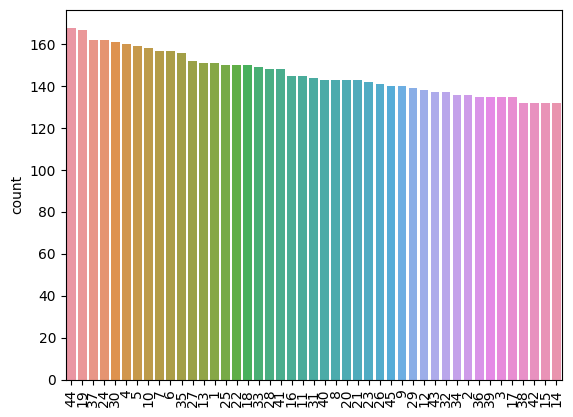

In [ ]:
sns.countplot(x=df2, order=order_df2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [ ]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [ ]:
count_exist = sorted(df2.unique())
count_exist = list(map(str, count_exist))

In [ ]:
temp = np.zeros((len(df.index), len(count_exist)))
temp = pd.DataFrame(temp, columns=count_exist)

In [ ]:
dict_ = dict.fromkeys(count_exist, 0)

In [ ]:
new_df = pd.concat([df, temp], axis=1)

In [ ]:
new_df.columns

Index(['Id', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'Date', 'Day', 'Month',
       'Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype='object')

In [ ]:
def count_(series):
    for index in ['N1', 'N2','N3','N4','N5','N6']:
      dict_[str(series.loc[index])] += 1

    for col in count_exist:
        series.loc[col] = dict_[col]
    return series

In [ ]:
new_df = new_df.apply(count_, axis=1)

In [ ]:
seq_data = new_df[['N1', 'N2','N3','N4','N5','N6']].values

In [ ]:
seq_data = torch.tensor(seq_data, dtype=torch.float32)

In [ ]:
features = new_df[['Id', 'Day', 'Month', 'Year', '1', '2', '3', '4', '5', '6',
                   '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
                   '17', '18', '19', '20', '21', '22', '23', '24',
                  '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
                  '37', '38', '39', '40', '41', '42', '43', '44', '45']].values

In [ ]:
features = StandardScaler().fit_transform(features)

In [ ]:
features = torch.tensor(features, dtype=torch.float32)

In [ ]:
len(seq_data), len(features)

(1096, 1096)

In [ ]:
class Seq_dataset(Dataset):
  def __init__(self, data_seq, data_fea, seq_length):
    self.data_seq = data_seq
    self.data_fea = data_fea
    self.seq_length = seq_length
  def __len__(self):
    return len(self.data_seq) - self.seq_length
  def __getitem__(self, index):
    X1 = self.data_seq[index: index + self.seq_length]
    X2 = self.data_fea[index + self.seq_length]
    y = self.data_seq[index + self.seq_length]
    return X1, X2, y

In [ ]:
temp_ = Seq_dataset(seq_data, features, 12)

In [ ]:
data_loader = DataLoader(temp_, batch_size=32, shuffle=True)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)

    hidden = self.init_hidden(batch_size)

    out, hidden = self.rnn(x, hidden)

    out = out.contiguous().view(-1, self.hidden_dim)
    out = self.fc(out)

    return out, hidden

  def init_hidden(self, batch_size):
    hidden = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
    return hidden

In [ ]:
class DNN(nn.Module):
  def __init__(self, input_size, output_size):
    super(DNN, self).__init__()
    self.fc = nn.Linear(input_size, output_size)

  def forward(self, x):
    out = torch.relu(self.fc(x))
    return out

In [ ]:
class Model(nn.Module):
  def __init__(self, RNN, DNN):
    super(Model, self).__init__()

    self.rnn = RNN
    self.dnn = DNN
    self.fc = nn.Linear(76, 6)

  def forward(self, x1, x2):
    out_1, hidden = self.rnn(x1)
    out_2 = self.dnn(x2)

    out_1 = out_1.view(out_2.size(0), -1)

    x = torch.cat((out_1, out_2), dim=1)
    x = self.fc(x)

    return x

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, data_loader):
  for epoch in range(1, n_epochs + 1):
    losses = []

    for x1, x2, y in data_loader:

      out = model(x1, x2)
      loss = loss_fn(out, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

    print(epoch, n_epochs, float(loss))

In [ ]:
rnn = RNN(input_size=6, output_size=4, hidden_dim=4, n_layers=1)
dnn = DNN(input_size=49, output_size=28)

model = Model(rnn, dnn)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

In [ ]:
training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    data_loader=data_loader
)

1 20 43.60730743408203
2 20 48.45248794555664
3 20 36.91109085083008
4 20 41.745826721191406
5 20 40.73054885864258
6 20 58.94823455810547
7 20 49.8690071105957
8 20 37.873802185058594
9 20 44.581695556640625
10 20 49.961639404296875
11 20 50.642391204833984
12 20 39.474369049072266
13 20 49.86110305786133
14 20 44.92387008666992
15 20 51.33370590209961
16 20 46.09192657470703
17 20 55.79863739013672
18 20 43.885467529296875
19 20 51.40926742553711
20 20 29.53347396850586


In [ ]:
model.eval()

Model(
  (rnn): RNN(
    (rnn): RNN(6, 4, batch_first=True)
    (fc): Linear(in_features=4, out_features=4, bias=True)
  )
  (dnn): DNN(
    (fc): Linear(in_features=49, out_features=28, bias=True)
  )
  (fc): Linear(in_features=76, out_features=6, bias=True)
)

In [ ]:
with torch.no_grad():
  x1_, x2_, y = next(iter(data_loader))
  y_1 = model(x1_, x2_)

  for i in range(len(y)):
    print(y_1[i].numpy().astype(int), y[i].numpy().astype(int))

[ 7 13 21 30 36 44] [19 24 31 32 35 36]
[ 6 12 20 29 36 43] [11 14 22 26 29 44]
[ 5 11 19 26 32 40] [ 4 16 19 27 29 30]
[ 5 11 19 29 35 43] [ 9 19 24 37 38 45]
[ 7 13 21 30 38 45] [ 8 18 30 32 38 45]
[ 6 12 19 28 35 42] [ 5 10 29 37 42 44]
[ 5 12 19 26 32 40] [ 5 13 21 27 29 45]
[ 6 12 20 29 35 43] [ 5 11 17 34 38 42]
[ 5 11 19 26 32 40] [ 1  9 18 28 36 44]
[ 5 11 19 28 35 43] [ 8 16 22 23 28 38]
[ 7 13 21 30 37 45] [ 7  8 30 35 40 44]
[ 5 11 19 27 33 41] [ 1  4 14 36 37 41]
[ 7 13 20 29 35 43] [ 2  3  9 15 17 43]
[ 7 13 21 30 38 45] [ 5 14 18 19 29 31]
[ 5 11 19 26 32 40] [12 18 31 34 35 42]
[ 5 11 19 26 31 39] [ 1  4  9 26 35 39]
[ 7 13 21 30 36 44] [ 3 14 20 22 37 44]
[ 6 13 22 31 38 46] [ 3  5  7 37 39 42]
[ 7 14 21 30 36 44] [ 2  3 16 19 22 34]
[ 6 13 20 29 36 43] [ 3  5  6  9 28 43]
[ 6 12 20 28 35 42] [ 1  3  7 12 22 25]
[ 5 12 19 26 32 39] [19 23 26 37 38 41]
[ 6 12 20 29 35 42] [ 6  7 11 16 23 44]
[ 6 12 20 29 35 43] [ 6 20 23 29 34 45]
[ 5 11 18 25 31 39] [ 6  8 25 39 40 45]
